## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
def mlp_compile(reduce_lr, name="unknown", Batch_Size=1024, results={}):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with %s" % (name))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-{0}".format(name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

def plotGraph(results):
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

## 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響

Experiment with patience-2
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
___________________________________________


Epoch 00040: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
Epoch 41/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.9257 - acc: 0.6943 - val_loss: 1.4399 - val_acc: 0.5027
Epoch 42/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.9260 - acc: 0.6933 - val_loss: 1.4399 - val_acc: 0.5030

Epoch 00042: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 43/50
50000/50000 [==============================] - 7s 141us/step - loss: 0.9257 - acc: 0.6937 - val_loss: 1.4399 - val_acc: 0.5031
Epoch 44/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.9251 - acc: 0.6933 - val_loss: 1.4399 - val_acc: 0.5034

Epoch 00044: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 45/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.9245 - acc: 0.6947 - val_loss: 1.4399 - val_acc: 0.5034
Epoch 46/50
50000/50000 [==============================] - 7s

50000/50000 [==============================] - 7s 136us/step - loss: 0.7760 - acc: 0.7517 - val_loss: 1.4933 - val_acc: 0.4933
Epoch 36/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.7652 - acc: 0.7577 - val_loss: 1.5039 - val_acc: 0.4926
Epoch 37/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7546 - acc: 0.7621 - val_loss: 1.5078 - val_acc: 0.4880
Epoch 38/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7431 - acc: 0.7660 - val_loss: 1.5086 - val_acc: 0.4942
Epoch 39/50
50000/50000 [==============================] - 7s 132us/step - loss: 0.7337 - acc: 0.7706 - val_loss: 1.5095 - val_acc: 0.4942

Epoch 00039: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 40/50
50000/50000 [==============================] - 7s 134us/step - loss: 0.7181 - acc: 0.7763 - val_loss: 1.5118 - val_acc: 0.4956
Epoch 41/50
50000/50000 [==============================] - 7s 133us/step - loss: 0.7080 - acc: 0.

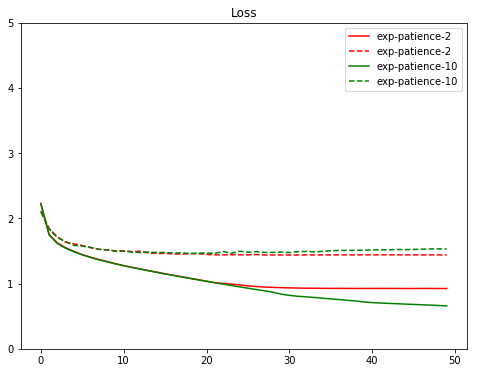

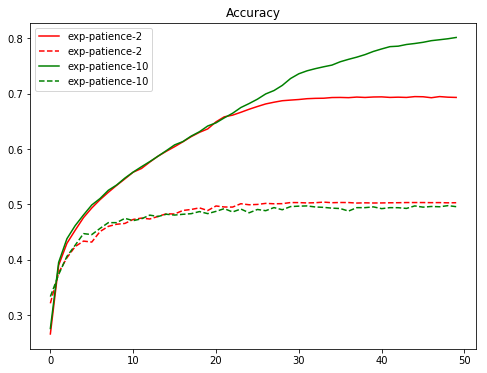

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

PATIENCES = [2, 10]

results = {}
for patience in PATIENCES:
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=patience, 
                                  verbose=1)
    name = "patience-{0}".format(patience)
    mlp_compile(name=name, reduce_lr=reduce_lr, results=results)

plotGraph(results)

Experiment with factor-0.1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)         

50000/50000 [==============================] - 7s 130us/step - loss: 0.8412 - acc: 0.7289 - val_loss: 1.4542 - val_acc: 0.5047
Epoch 48/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.8415 - acc: 0.7282 - val_loss: 1.4542 - val_acc: 0.5047

Epoch 00048: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.
Epoch 49/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.8420 - acc: 0.7268 - val_loss: 1.4542 - val_acc: 0.5045
Epoch 50/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.8417 - acc: 0.7273 - val_loss: 1.4542 - val_acc: 0.5044
Experiment with factor-0.5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
__________________

50000/50000 [==============================] - 6s 127us/step - loss: 0.8500 - acc: 0.7239 - val_loss: 1.4578 - val_acc: 0.5032
Epoch 43/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.8483 - acc: 0.7263 - val_loss: 1.4582 - val_acc: 0.5006
Epoch 44/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.8471 - acc: 0.7249 - val_loss: 1.4591 - val_acc: 0.5004

Epoch 00044: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 45/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.8443 - acc: 0.7265 - val_loss: 1.4585 - val_acc: 0.5012
Epoch 46/50
50000/50000 [==============================] - 6s 130us/step - loss: 0.8433 - acc: 0.7269 - val_loss: 1.4582 - val_acc: 0.5018
Epoch 47/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.8421 - acc: 0.7286 - val_loss: 1.4592 - val_acc: 0.5027
Epoch 48/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.8426 - acc: 0.

50000/50000 [==============================] - 7s 147us/step - loss: 0.7495 - acc: 0.7627 - val_loss: 1.5025 - val_acc: 0.4904
Epoch 38/50
50000/50000 [==============================] - 7s 147us/step - loss: 0.7359 - acc: 0.7690 - val_loss: 1.4988 - val_acc: 0.4981
Epoch 39/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.7226 - acc: 0.7741 - val_loss: 1.5111 - val_acc: 0.4999
Epoch 40/50
50000/50000 [==============================] - 7s 148us/step - loss: 0.7092 - acc: 0.7788 - val_loss: 1.5261 - val_acc: 0.4912

Epoch 00040: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
Epoch 41/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.6931 - acc: 0.7860 - val_loss: 1.5287 - val_acc: 0.4932
Epoch 42/50
50000/50000 [==============================] - 7s 147us/step - loss: 0.6802 - acc: 0.7908 - val_loss: 1.5406 - val_acc: 0.4876
Epoch 43/50
50000/50000 [==============================] - 7s 146us/step - loss: 0.6676 - acc: 0.

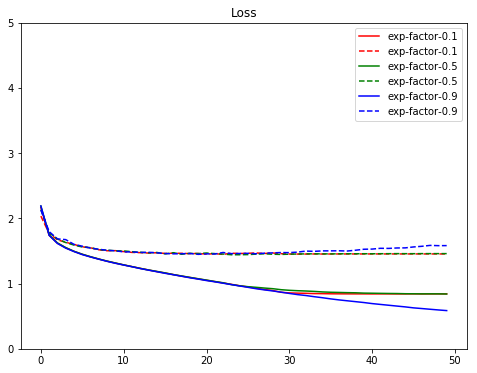

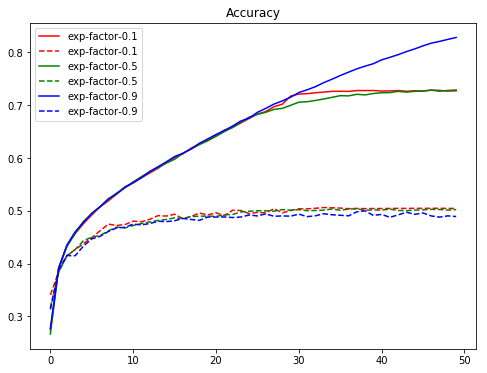

In [10]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

FACTORS = [0.1, 0.5, 0.9]

results = {}
for factor in FACTORS:
    reduce_lr = ReduceLROnPlateau(factor=factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=5, 
                                  verbose=1)
    name = "factor-{0}".format(factor)
    mlp_compile(name=name, reduce_lr=reduce_lr, results=results)

plotGraph(results)

## 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [11]:
def mlp_compile2(reduce_lr, name="unknown", optimizer="sgd", Batch_Size=1024, results={}):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with %s" % (name))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-{0}".format(name)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with optimizer-sgd
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)      

50000/50000 [==============================] - 7s 146us/step - loss: 0.9492 - acc: 0.6846 - val_loss: 1.4625 - val_acc: 0.4936
Epoch 48/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.9480 - acc: 0.6836 - val_loss: 1.4626 - val_acc: 0.4932
Epoch 49/50
50000/50000 [==============================] - 8s 159us/step - loss: 0.9463 - acc: 0.6845 - val_loss: 1.4645 - val_acc: 0.4933

Epoch 00049: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
Epoch 50/50
50000/50000 [==============================] - 8s 152us/step - loss: 0.9432 - acc: 0.6864 - val_loss: 1.4626 - val_acc: 0.4937
Experiment with optimizer-adam
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
______________

50000/50000 [==============================] - 8s 163us/step - loss: 0.2436 - acc: 0.9534 - val_loss: 1.7179 - val_acc: 0.5253
Epoch 42/50
50000/50000 [==============================] - 8s 163us/step - loss: 0.2426 - acc: 0.9537 - val_loss: 1.7267 - val_acc: 0.5222
Epoch 43/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.2405 - acc: 0.9548 - val_loss: 1.7275 - val_acc: 0.5229
Epoch 44/50
50000/50000 [==============================] - 8s 167us/step - loss: 0.2394 - acc: 0.9553 - val_loss: 1.7309 - val_acc: 0.5236

Epoch 00044: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 45/50
50000/50000 [==============================] - 8s 163us/step - loss: 0.2365 - acc: 0.9564 - val_loss: 1.7296 - val_acc: 0.5237
Epoch 46/50
50000/50000 [==============================] - 8s 164us/step - loss: 0.2355 - acc: 0.9565 - val_loss: 1.7320 - val_acc: 0.5241
Epoch 47/50
50000/50000 [==============================] - 8s 165us/step - loss: 0.2345 - acc: 0.

Epoch 36/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.3795 - acc: 0.8962 - val_loss: 1.6148 - val_acc: 0.5285

Epoch 00036: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 37/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.3668 - acc: 0.9015 - val_loss: 1.6123 - val_acc: 0.5312
Epoch 38/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.3635 - acc: 0.9030 - val_loss: 1.6192 - val_acc: 0.5325
Epoch 39/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3608 - acc: 0.9048 - val_loss: 1.6298 - val_acc: 0.5329
Epoch 40/50
50000/50000 [==============================] - 7s 136us/step - loss: 0.3582 - acc: 0.9058 - val_loss: 1.6219 - val_acc: 0.5330
Epoch 41/50
50000/50000 [==============================] - 7s 135us/step - loss: 0.3560 - acc: 0.9065 - val_loss: 1.6311 - val_acc: 0.5318

Epoch 00041: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epo

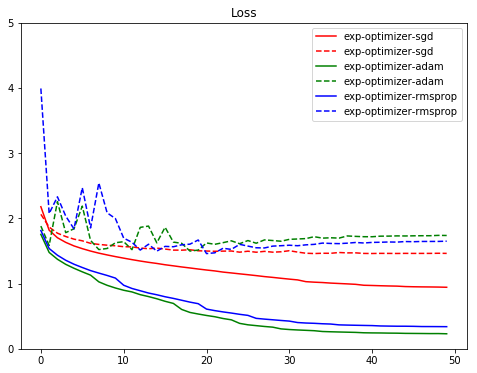

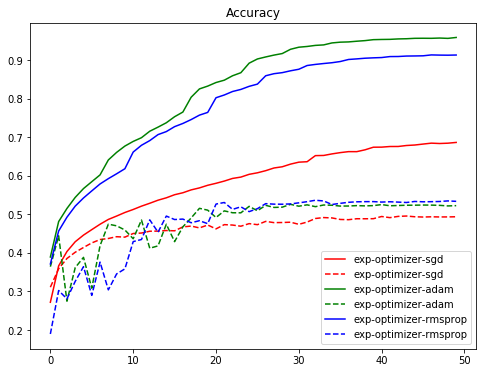

In [12]:
OPTIMIZERS = ["sgd", "adam", "rmsprop"]

results = {}
for optimizer in OPTIMIZERS:
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=5, 
                                  verbose=1)
    name = "optimizer-{0}".format(optimizer)
    mlp_compile2(name=name, reduce_lr=reduce_lr, optimizer=optimizer, results=results)

plotGraph(results)